# **Group 37: DSCI 100 - Physical Characteristics of Tennis Players Influencing their Likelihood of Winning Matches**

----------------------------------------------------------


## Research question: do tennis players' physical characteristics influence the likelihood of winning a game?


## Introduction
Our project aims to identify the likelihood of winning (or losing) tennis matches in the ATP tournament based on a player’s physical characteristics such as height and age. Our dataset is taken from a database which compiles ATP tournament match data from 2020 (Sackmann, 2020). The ATP Tour is a global top-level male tennis tour organised by the Association of Tennis Professionals (ATP). 

While our dataset contains 49 columns and almost 1500 rows, we are whittling this down to focus on exclusively physical characteristic data of players. We have also created a new binary variable, `win_lose`, which indicates the overall result of a tennis match. Our project will focus on a $K$-nearest neighbours classification analysis of our two classifier variables and our one predictor variable. We will try to predict the outcome of  a match based on players' age and height.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading the dataset into Jupyter
x <- getURL("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2020.csv")
match_data <- read.csv(text = x)

In [3]:
#Table 1.1
match_data

tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2020-8888,Atp Cup,Hard,24,A,20200106,300,104925,NA,,⋯,51,39,6,10,6,8,2,9055,1,9985
2020-8888,Atp Cup,Hard,24,A,20200106,299,105138,NA,,⋯,35,21,6,9,5,10,10,2335,34,1251
2020-8888,Atp Cup,Hard,24,A,20200106,298,104925,NA,,⋯,57,35,25,14,6,11,2,9055,5,5705
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2020-7485,Antwerp,Hard,32,A,20201019,128,126203,7,,⋯,37,30,5,9,3,5,28,1670,33,1402
2020-7485,Antwerp,Hard,32,A,20201019,129,144750,NA,Q,⋯,45,29,5,10,7,11,90,748,74,838
2020-7485,Antwerp,Hard,32,A,20201019,130,200005,NA,,⋯,32,26,7,9,2,4,38,1306,172,353


 _**Table 1.1**_

We will first split the match_data into two tables based on whether a player won or lost their match, then we will
add a variable indicating if it's a win or loss and we will select for the variables of interest which are height, age and match_result because we are focusing on investigating how the physical characteristics of tennis player influence its likelihood of winning.
After, we will rename height and age's column names to remove redundancy and improve consistency. We will put the two tables of win and lose into one data frame for later use. 

In [4]:
match_data_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_ht, winner_age, match_result) |>
                    rename(ht = winner_ht, age = winner_age)

match_data_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_ht, loser_age, match_result) |>
                    rename(ht = loser_ht, age = loser_age)

match_data_tidy <- bind_rows(match_data_winner, match_data_loser)

In [5]:
#Table 1.2 This is the dataframe we are going to split into training and testing models to predict the match result.
match_data_tidy

ht,age,match_result
<int>,<dbl>,<chr>
188,32.6,win
183,31.7,win
188,32.6,win
⋮,⋮,⋮
211,23.1,lose
178,21.5,lose
180,26.6,lose


_**Table 1.2**_

In [6]:
set.seed(1)
#Seperating the Data into training and test sets, with a training/testing split of 75/25% based on the match result
match_split <- initial_split(match_data_tidy, prop = 0.75, strata = match_result)

# training set
match_train <- training(match_split)

# testing set
match_test <- testing(match_split)

In [7]:
#Check number of missing values in each column of the table ONLY USING TRAINING DATA
num_na <- match_train |> 
            summarize_all(~sum(is.na(.))) 

In [8]:
#Table 1.3 There are 36 missing values in the height column.
num_na

ht,age,match_result
<int>,<int>,<int>
36,0,0


_**Table 1.3**_

In [9]:
#remove NA tuples from datasets
match_train <- filter(match_train, !is.na(ht))
match_test <- filter(match_test, !is.na(ht))

**NOTE**: 
Of the 2934 tuples in our dataset, 36 of them have a NA value in one of the variables of interest. Thats only slightly more than 1% of the data, so the dataset is still suitable for analysis.

In [10]:
#Histograms of the height and age variable distributions ONLY USING TRAINING DATA
options(repr.plot.width = 13, repr.plot.height =8)
prelim_hist_height <- ggplot(data = match_train, aes(x = ht))+
                geom_histogram(binwidth = 5, color = "black", fill = "white")+
                labs(x = "Height (cm)", y = "Count")+
                ggtitle("Distribution of Height")+
                theme(text = element_text(size = 20))

prelim_hist_age <- ggplot(data = match_train, aes(x = age))+
                geom_histogram(binwidth = 2, color = "black", fill = "white")+
                labs(x = "Age (years)", y = "Count")+
                ggtitle("Distribution of Age")+
                theme(text = element_text(size = 20))

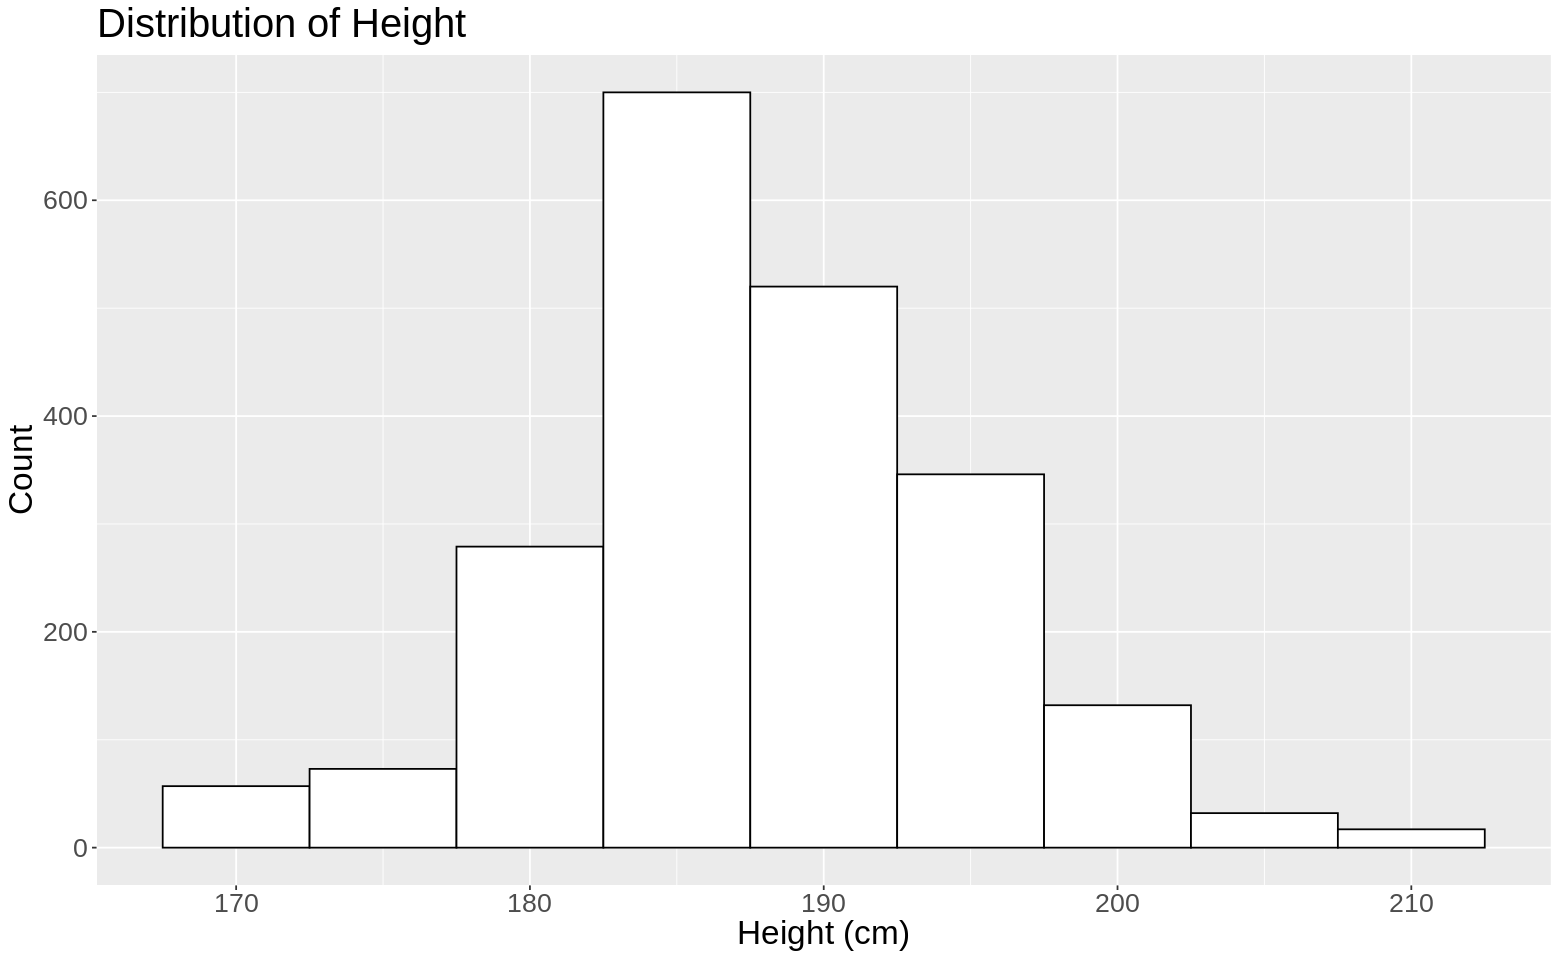

In [11]:
# Figure1.1 To look at the distribution of height
prelim_hist_height

_**Figure 1.1**_

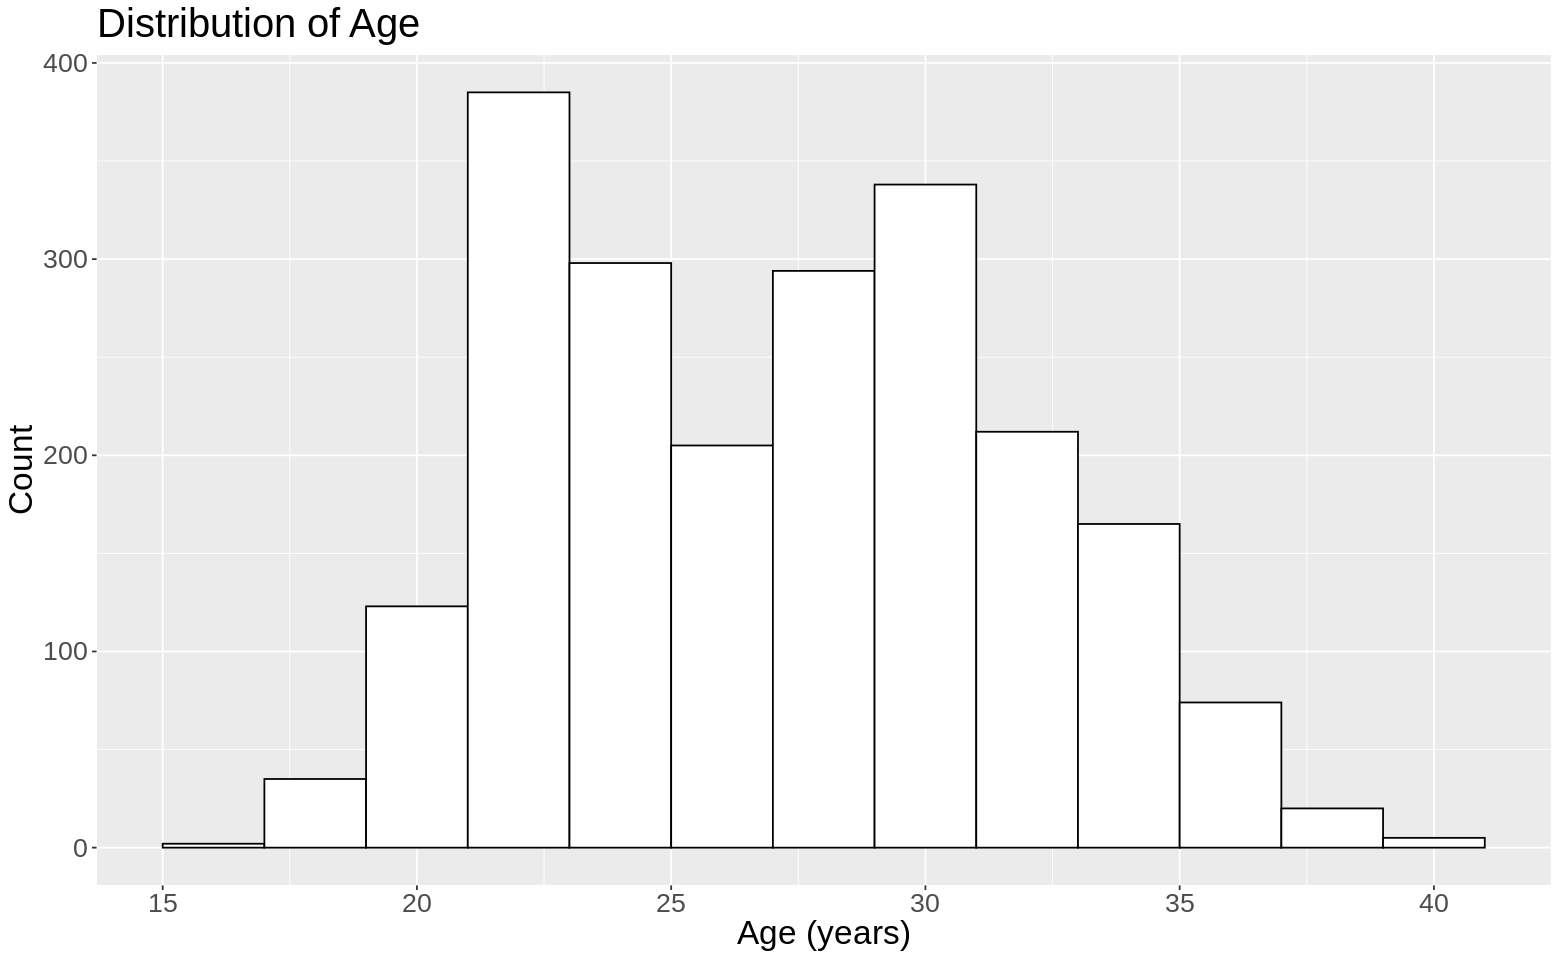

In [12]:
# Figure1.2 To look at the distribution of age
prelim_hist_age 

_**Figure 1.2**_

In [13]:
#This step is to check the percentage of winning and losing in the data set to make sure one don't outweigh the other
match_proportions <- match_train |>
                      group_by(match_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(match_train))

In [14]:
#Table 1.4 There's roughly 49.5% of losing data in the training dataset and
# 50.5% of winning data. 
match_proportions 

match_result,n,percent
<chr>,<int>,<dbl>
lose,1068,49.53618
win,1088,50.46382


_**Table 1.4**_

In [15]:
# Change datatype of match_result from character to factor in order for the next few functions to work 
# and successfully classify if it's a win or lose
match_train$match_result <- as.factor(match_train$match_result)
match_test$match_result <- as.factor(match_test$match_result)

In [16]:
#setup standard recipe, setup knn_spec to tune for the best k value

match_recipe <- recipe(match_result ~ ht + age, data = match_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [17]:
#trying 10 different k values, count by every 3 from 1 to 30
set.seed(1)
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 3))

match_vfold <- vfold_cv(match_train, v = 5, strata = match_result)

knn_results <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = match_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

In [18]:
#Table 1.5 This is the accuracy table for each k value from 1 to 30 counting by 3
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4893239,5,0.004122565,Preprocessor1_Model01
4,accuracy,binary,0.4893389,5,0.008169541,Preprocessor1_Model02
7,accuracy,binary,0.5204113,5,0.004370763,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,accuracy,binary,0.5115762,5,0.009098828,Preprocessor1_Model08
25,accuracy,binary,0.4986176,5,0.006734890,Preprocessor1_Model09
28,accuracy,binary,0.5009173,5,0.004052229,Preprocessor1_Model10


_**Table 1.5**_

In [19]:
#plotting accuracies of different k, best seems to be 10
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

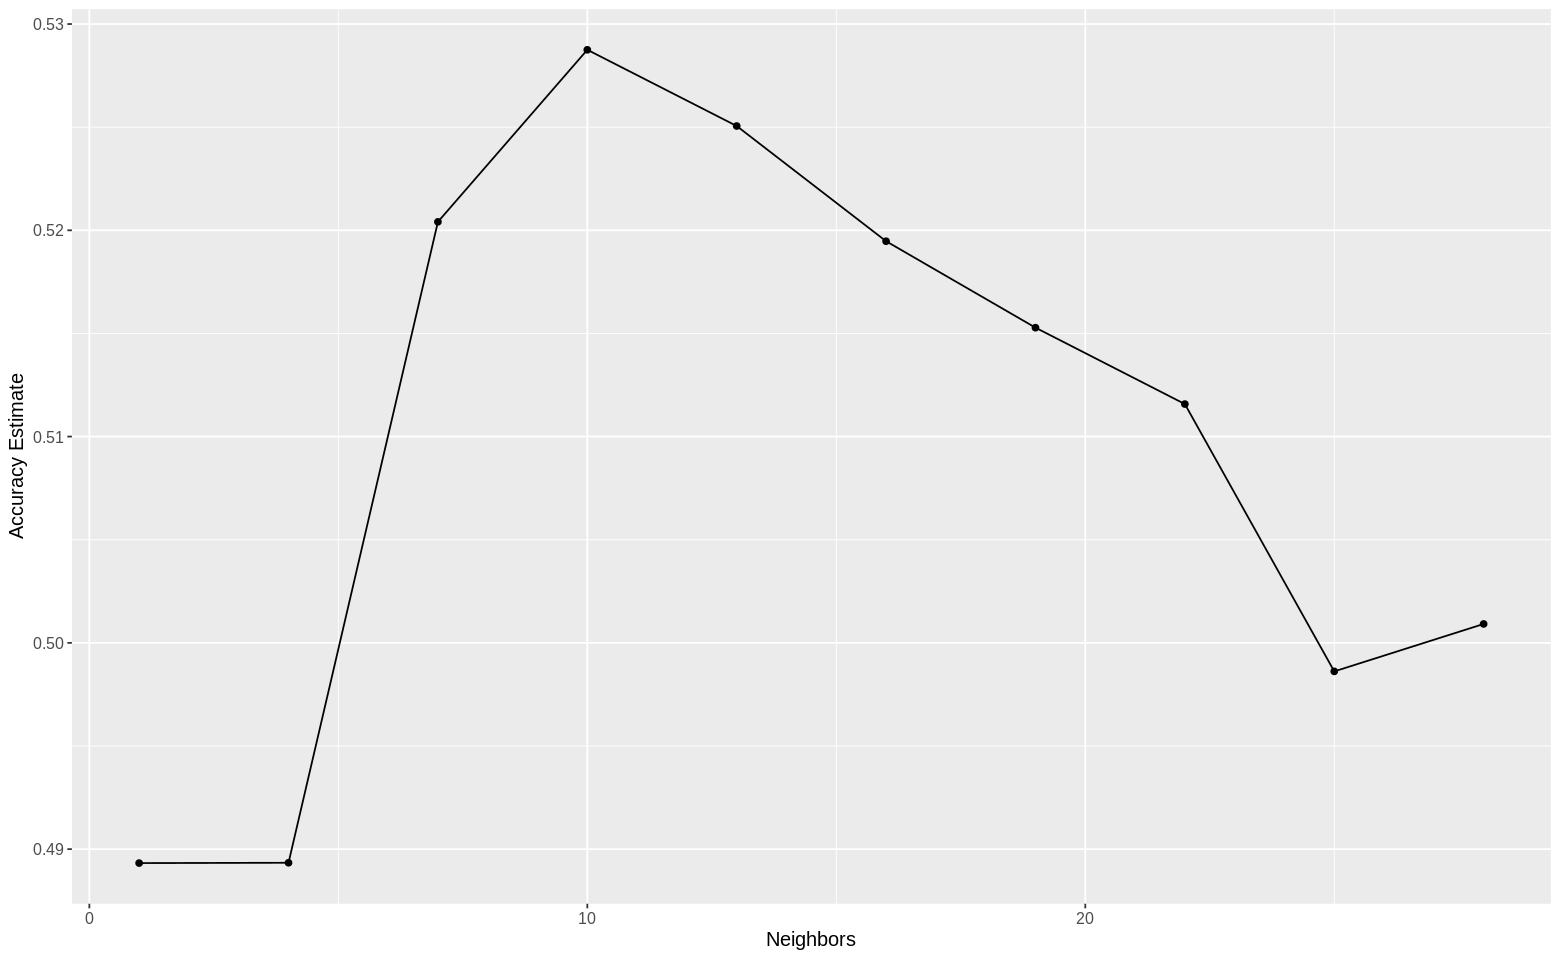

In [20]:
#Figure 1.3 This is the graph with k values on x axis and its accuracy on y axis
# it seems that the highest accuracy is when k is 10 with an accuracy of 53% roughly.
accuracy_vs_k 

_**Figure 1.3**_

The best K value seems to be 10 because it has the highest accuracy value as it is at the peak of the plot. 

In [25]:
#display accuracy of model using best k and cross-validation 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = match_vfold)

accuracy_value <- knn_fit |> 
  collect_metrics() 

In [26]:
#Table 1.6 The table shows our model has an accuracy of 53%.
accuracy_value

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5287511,5,0.009752368,Preprocessor1_Model1
roc_auc,binary,0.5455527,5,0.011857998,Preprocessor1_Model1


_**Table 1.6**_

In [27]:
#test predictions using test-data
set.seed(1)
knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit(match_train)

match_test_predictions <- predict(knn_fit, match_test) |>
  bind_cols(match_test)

accuracy_only <- match_test_predictions |>
  metrics(truth = match_result, estimate = .pred_class) |>
  filter(.metric == "accuracy")


confusion <- match_test_predictions |>
             conf_mat(truth = match_result, estimate = .pred_class)

In [28]:
#Table 1.7 The table shows a 55% accuracy on how accurate our model predicts our test data
accuracy_only

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5520111


In [29]:
#Table 1.8 It shows the prediction of our model
match_test_predictions

.pred_class,ht,age,match_result
<fct>,<int>,<dbl>,<fct>
win,183,31.7,win
lose,180,29.0,win
lose,188,32.6,win
⋮,⋮,⋮,⋮
lose,181,31.2,lose
lose,185,27.8,lose
lose,188,32.7,lose


_**Table 1.8**_

In [30]:
#Table 1.8 The confusion matrix shows a summary of the prediction where it predicts 230 losing data 
# to be losing and 195 winning data to be losing. It predicts 128 losing data to be winning and 168 
# winning data to be winning and overall has an accuracy of 55%.
confusion

          Truth
Prediction lose win
      lose  230 195
      win   128 168

_**Table 1.9**_

In [31]:
#creating a new column to determine how accurate our predictions are and 
# graph plotting predictions vs real values

prediction_accuracy <- match_test_predictions |>
    mutate(predict_accuracy = .pred_class == match_result)

prediction_plot <- ggplot(data = match_test_predictions,aes(x= ht, y=age, color = match_result, shape = .pred_class))+
                        geom_point(size = 3) + labs(x = "Height (cm)", y = "Age (years)")

prediction_plot2 <- ggplot(data = prediction_accuracy,aes(x= ht, y=age, color = predict_accuracy))+
                        geom_point(size = 3) + labs(x = "Height (cm)", y = "Age (years)")

In [32]:
#Table 2.0 It shows the prediction's accuracy by saying it's true or false
prediction_accuracy

.pred_class,ht,age,match_result,predict_accuracy
<fct>,<int>,<dbl>,<fct>,<lgl>
win,183,31.7,win,TRUE
lose,180,29.0,win,FALSE
lose,188,32.6,win,FALSE
⋮,⋮,⋮,⋮,⋮
lose,181,31.2,lose,TRUE
lose,185,27.8,lose,TRUE
lose,188,32.7,lose,TRUE


_**Table 2.0**_

In [37]:
#creating a new column to determine how accurate our predictions are
prediction_accuracy <- match_test_predictions |>
    mutate(predict_accuracy = .pred_class == match_result)

#to visualize the prediction accuracy
prediction_accuracy_plot <- ggplot(data = prediction_accuracy,aes(x= ht, y= age, fill = predict_accuracy)) +
                        geom_bar(stat = "identity") + labs(x = "Height (cm)", y = "counts", fill = "Predictor Accuracy (True or False)")

#to list out accurate and false predictions and expected outcomes
predict_accurate <- prediction_accuracy |> 
    count(.pred_class, match_result) |>
    mutate(predict_accuracy = .pred_class == match_result)
    #pivot_wider(names_from = predict_accuracy, values_from = n)

#to visualize the total number of true and false predictions
predict_accurate_plot <- ggplot(predict_accurate, aes(x= predict_accuracy, y=n)) +
                        geom_bar(stat = "identity") + labs(x = "Prediction Accuracy (true or false)", y = "Count")

#total number of predicted win and lose
pred_class_data <- prediction_accuracy |>
    count(.pred_class)

#actual total number of win and lose
match_result_data <- prediction_accuracy |>
    count(match_result)

#to visualize the count of predicted win and lose
pred_class_plot <- ggplot(pred_class_data, aes(x= .pred_class, y= n)) +
                        geom_bar(stat = "identity") + labs(x = "Prediction (win or lose)", y = "Count")

#to visualize the actual count of win and lose
match_result_plot <- ggplot(match_result_data, aes(x= match_result, y= n)) +
                        geom_bar(stat = "identity") + labs(x = "Actual Result (win or lose)", y = "Count")

In [38]:
#Table 2.0
prediction_accuracy

.pred_class,ht,age,match_result,predict_accuracy
<fct>,<int>,<dbl>,<fct>,<lgl>
win,183,31.7,win,TRUE
lose,180,29.0,win,FALSE
lose,188,32.6,win,FALSE
⋮,⋮,⋮,⋮,⋮
lose,181,31.2,lose,TRUE
lose,185,27.8,lose,TRUE
lose,188,32.7,lose,TRUE


_**Table 2.0**_

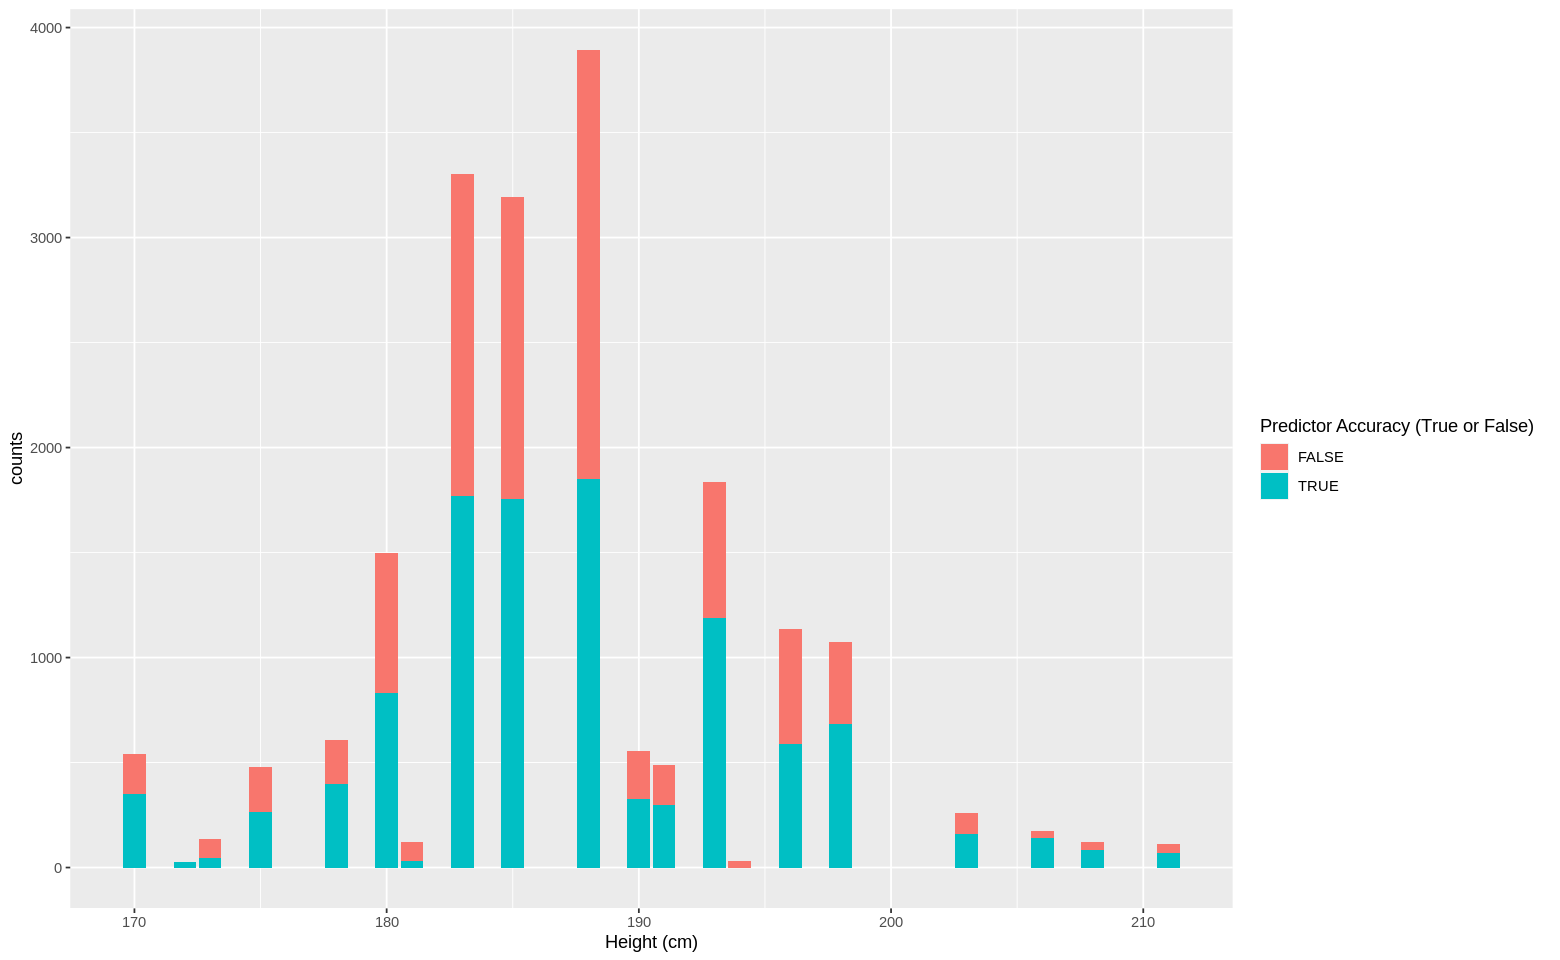

In [39]:
#Figure 1.4 The graph shows 
prediction_accuracy_plot

_**Figure 1.6**_

In [32]:
#Table 2.1 Shows confusion matrix in a table for later graphs
predict_accurate

.pred_class,match_result,n,predict_accuracy
<fct>,<fct>,<int>,<lgl>
lose,lose,230,TRUE
lose,win,195,FALSE
win,lose,128,FALSE
win,win,168,TRUE


_**Table 2.1**_

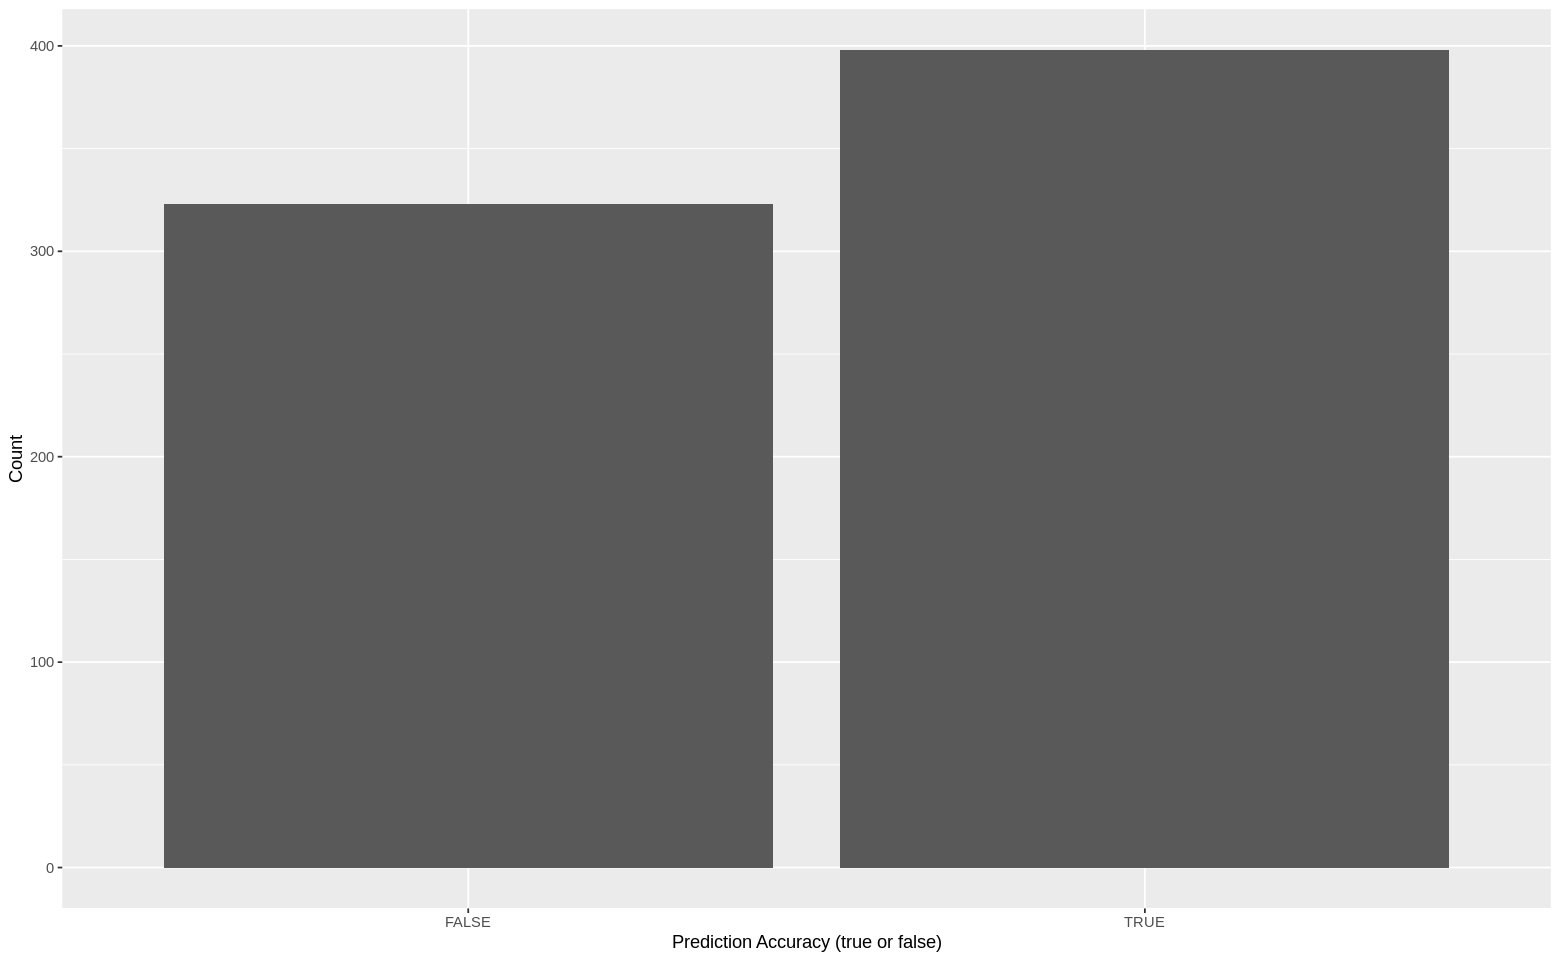

In [33]:
#Figure 1.4 To visualize the sum of model's accurate and false predictions
predict_accurate_plot

_**Figure 1.4**_

In [34]:
#Table 2.2 Table for the sum of prediction counts only
pred_class_data

.pred_class,n
<fct>,<int>
lose,425
win,296


_**Table 2.2**_

In [35]:
#Table 2.3 Table for the sum of actual match results data counts only
match_result_data

match_result,n
<fct>,<int>
lose,358
win,363


**_Table 2.3_**

# INCLUDE FACET_GRID

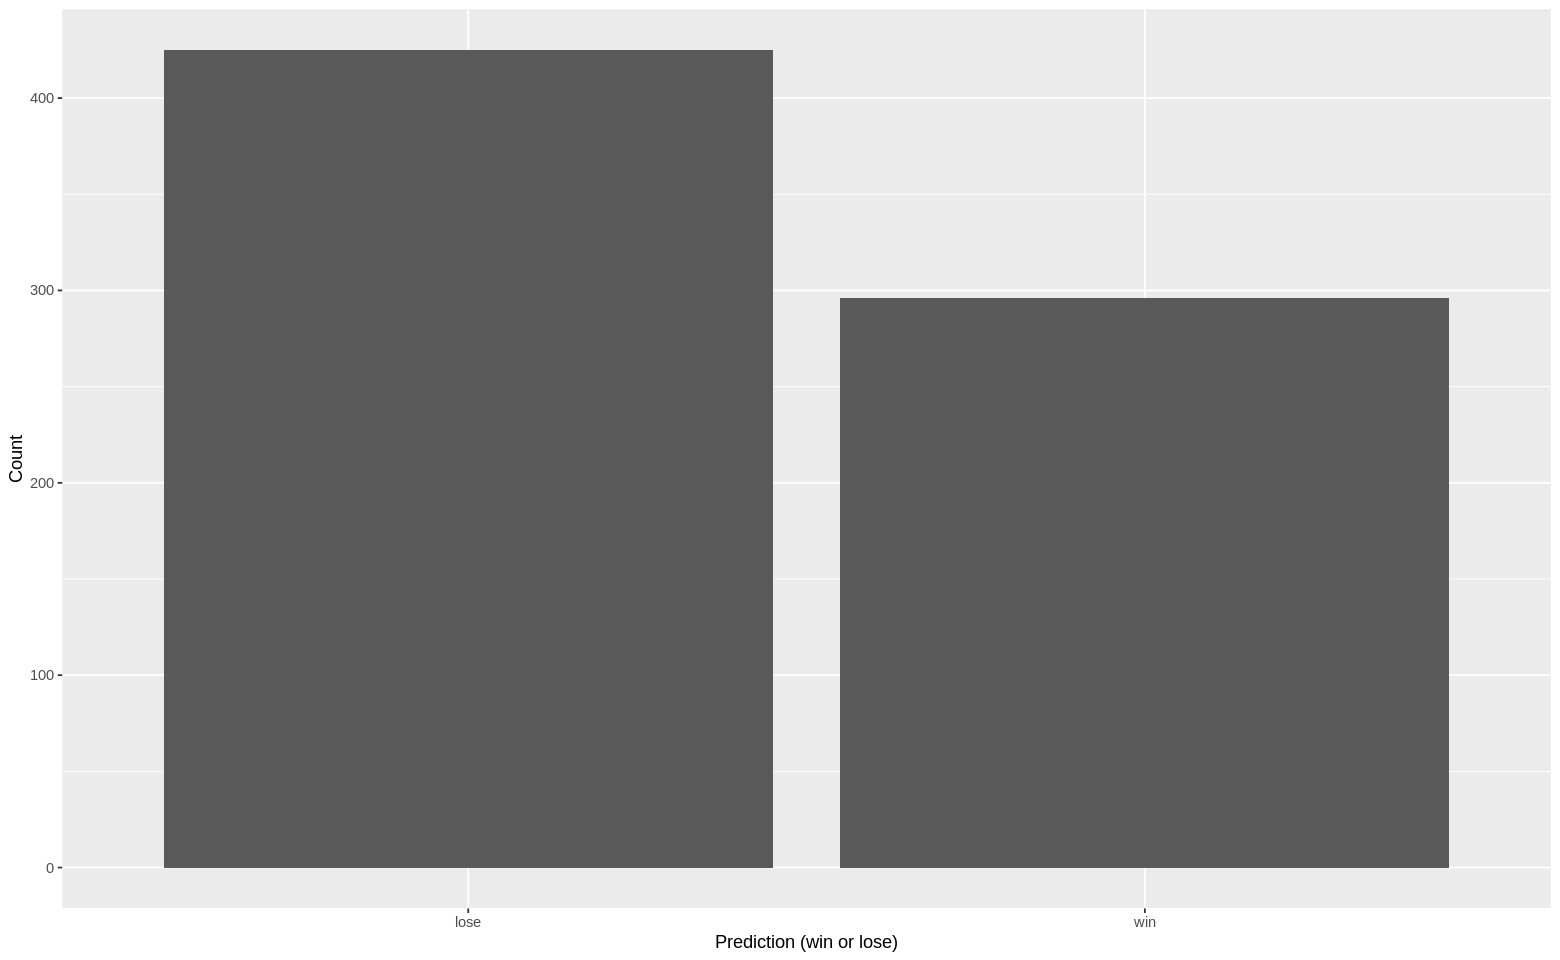

In [40]:
#Figure 1.5 To visualize the prediction results's total number of win and lose
pred_class_plot

_**Figure 1.5**_

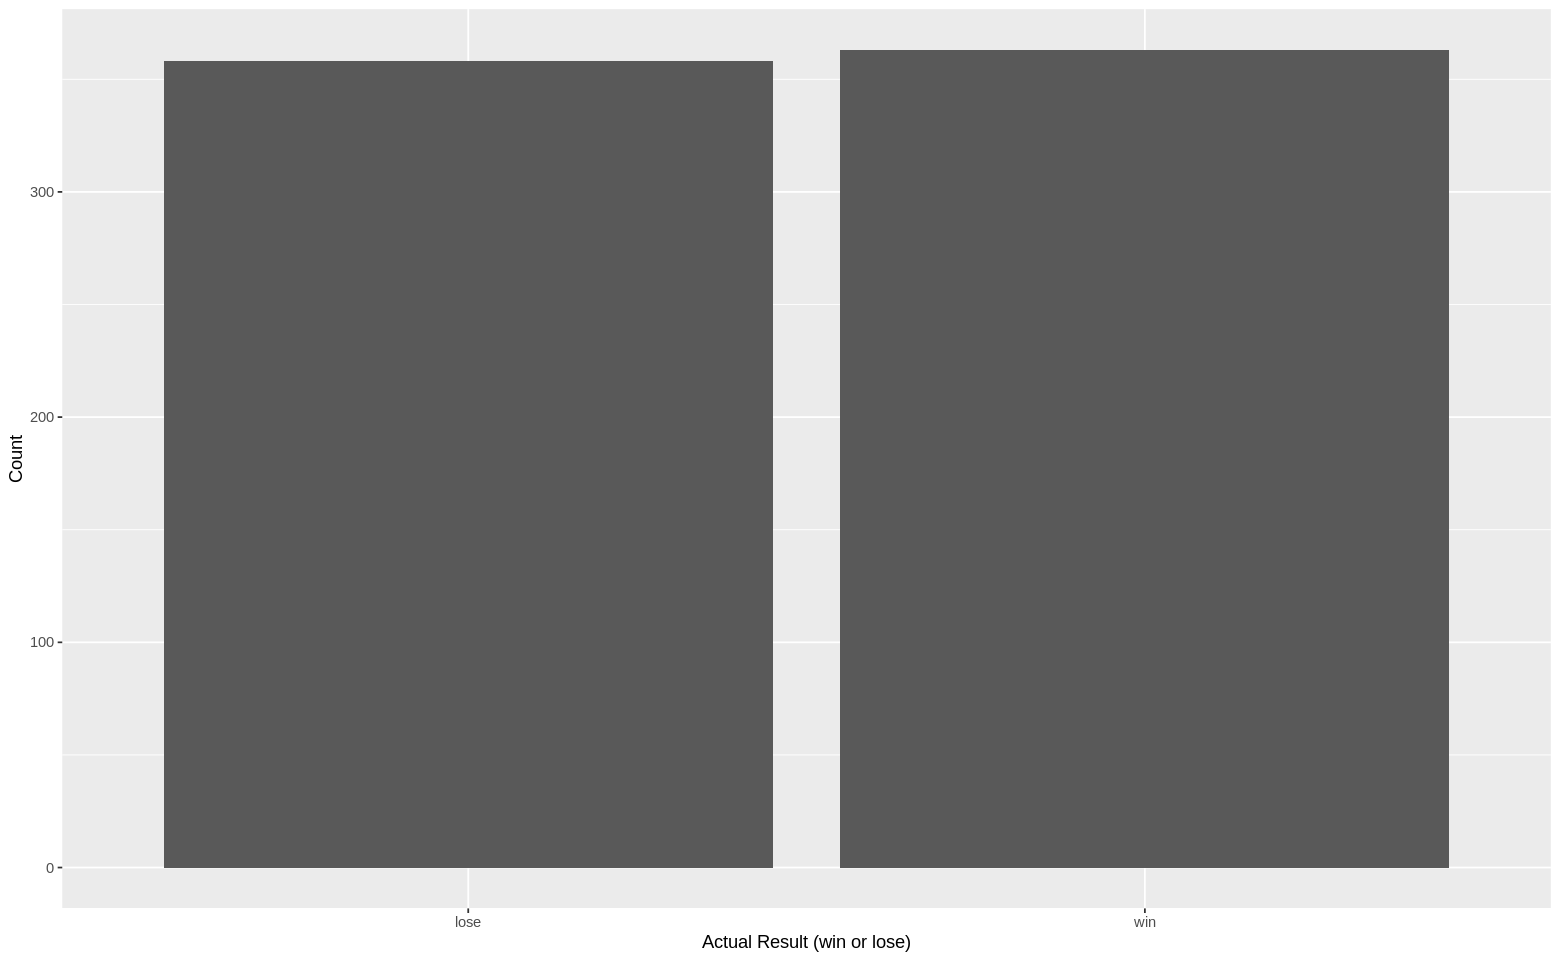

In [37]:
#Figure 1.6 To visualize the actual match results's total number of win and lose
match_result_plot

_**Figure 1.6**_

## Forward Selection

In [42]:
#adding column for match result, and combining variables that are separated as "winner" and "loser" into one column
#need to add "hand" column and decide which predictors to use
set.seed(1)
match_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_hand, winner_ht, winner_age, match_result, winner_rank, minutes, contains("w_")) |>
                    rename(hand = winner_hand, ht = winner_ht, age = winner_age, rank = winner_rank, ace = w_ace, df = w_df, svpt = w_svpt,
                           firstIn = w_1stIn, firstWon = w_1stWon, secondWon = w_2ndWon, SvGms = w_SvGms, bpSaved = w_bpSaved, bpFaced = w_bpFaced)

match_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_hand, loser_ht, loser_age, match_result, loser_rank, minutes, contains("l_")) |>
                    rename(hand = loser_hand, ht = loser_ht, age = loser_age, rank = loser_rank, ace = l_ace, df = l_df, svpt = l_svpt,
                           firstIn = l_1stIn, firstWon = l_1stWon, secondWon = l_2ndWon, SvGms = l_SvGms, bpSaved = l_bpSaved, bpFaced = l_bpFaced)

match_tidy <- bind_rows(match_winner, match_loser)

match_tidy_l <- match_tidy |>
                filter(hand == "L") |>
                mutate(hand = 0)

match_tidy_r <- match_tidy |>
                filter(hand == "R") |>
                mutate(hand = 1)


match_tidy_hands <- bind_rows(match_tidy_l, match_tidy_r)

#loading data with all potentional predictors
match_data_subset <- match_tidy_hands |>
    select(match_result,
           hand,
           ht,
           age,
           rank,
           minutes,
           ace,
           df,
           svpt,
           firstWon,
           firstIn,
           secondWon,
           SvGms,
           bpSaved,
           bpFaced) |> na.omit()

names <- colnames(match_data_subset |> select(-match_result))


In [43]:
#Table 2.4 Adding the new hand column and changing the hand column from character to a real number
match_tidy_hands

hand,ht,age,match_result,rank,minutes,draw_size,ace,df,svpt,firstIn,firstWon,secondWon,SvGms,bpSaved,bpFaced
<dbl>,<int>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,185,33.5,win,1,133,24,5,3,84,61,48,10,15,1,3
0,185,33.5,win,1,127,24,7,3,76,48,33,18,11,6,8
0,185,33.5,win,1,109,24,2,2,56,35,26,12,11,2,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,185,27.8,lose,79,115,NA,4,1,77,43,31,14,13,3,7
1,211,23.1,lose,33,67,NA,19,3,58,37,30,5,9,3,5
1,180,26.6,lose,172,73,NA,2,0,49,32,26,7,9,2,4


In [44]:
#Table 2.5 Select all the potential predictors into this dataframe
match_data_subset

,match_result,hand,ht,age,rank,minutes,ace,df,svpt,firstWon,firstIn,secondWon,SvGms,bpSaved,bpFaced
,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,win,0,185,33.5,1,133,5,3,84,48,61,10,15,1,3
2,win,0,185,33.5,1,127,7,3,76,33,48,18,11,6,8
3,win,0,185,33.5,1,109,2,2,56,26,35,12,11,2,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2890,lose,1,185,27.8,79,115,4,1,77,31,43,14,13,3,7
2891,lose,1,211,23.1,33,67,19,3,58,30,37,5,9,3,5
2892,lose,1,180,26.6,172,73,2,0,49,26,32,7,9,2,4


_**Table 2.5**_

In [45]:
predictor_formula <- paste("match_result", "~", paste(names, collapse="+"))
predictor_formula

[1] "match_result ~ hand+ht+age+rank+minutes+ace+df+svpt+firstWon+firstIn+secondWon+SvGms+bpSaved+bpFaced"

In [ ]:
set.seed(1)
accuracies <- tibble(size = integer(), #Table 3.2
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

match_vfold <- vfold_cv(match_data_subset, v = 5, strata = match_result)

n_total <- length(names)

selected <- c()

for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("match_result", "~", paste(preds_new, collapse="+"))

       match_recipe <- recipe(as.formula(model_string), 
                                data = match_data_subset) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        acc <- workflow() |>
          add_recipe(match_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = match_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        accs[[j]] <- acc
        models[[j]] <- model_string
        }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [ ]:
accuracies <- accuracies |> arrange(desc(accuracy)) 

In [ ]:
#Table 2.6 To check which potential factors and how many of them will give us the most accuracy in predicting
accuracies

# FORWARD SELECTION DISCUSSION
- other vars can indeed predict better the result but aren't physical characteristics

Advantages & disadvantages
- long computing time

**_Table 3.2_**

# talk about length to run because we're trying many different vars in fwd selection

## Discussion: WILL BE UPDATED

        #summarize what you found
        #discuss whether this is what you expected to find?
        #discuss what impact could such findings have?
        #discuss what future questions could this lead to?

### **What we found**

Our $k$-nearest neighbours algorithm allowed us to predict the value of a categorical variable (the win/loss of a match) by basing our predictive algorithm on two quantitative variables (height and age of a tennis player in the ATP open). 

For this analysis, we chose a $k$-nearest neighbours ($k$-nn) algorithm to predict the result of a new potential value to classify. $K$-nn algorithms have an advantage to other machine-learning algorithms, according to Moldagulova and Sulaiman (2017) because of their ease of interpretation. Timbers _et al._ (2022) also suggest that the $k$-nn algorithm is also simple and intuitive.

In our $k$-nn classification algorithm, we followed all the standard procedures as outlined by Timbers _et al._ (2022). First, we tidied the dataset and then split it into 'training' and 'testing' segments. We first built the model using the training segment of 75% of the original dataset. The testing dataset helps us later to evaluate the model on data it has not seen before (therefore 25% of the original dataset).

Subsequently, we tuned the classifier (by selecting the number of $k$s in the $k$-nn algorithm) through maximising its estimated accuracy by cross-validating. We chose k = 13 after cross-validation because it maximised estimated accuracy (_see Figure 1.3_)

In our analysis, we found that height and age have very little predictive power for the end result of a tennis match. The algorithm  predicted a loss 207 times where it should have been a loss but 187 times when it should have been a win according to our testing dataset (_see the confusion matrix_). In fact, the impact of height and age only explained 53.12% of wins in the dataset—essentially only marginally better than pure chance. 

### **What we expected to find**

Our expected outcomes differed significantly from our findings. As written in our proposal, we expected our selected physical characteristics to have a key role in determining the outcome of the end result of a tennis match. For height, we believed that the taller players will be more likely to win because their height will translate to longer arms and legs; this would give them a greater advantage than those who are shorter. For age, we expected that older players will be less likely to win because older players are more liable to injuries and health conditions, impacting their athletic abilities. Overall, we expected individuals who are tall and of a younger age to be the ideal players to win more matches. However, our results showed that age and height have little effect on matches' outcomes—the end accuracy of our model was only 53.12%. 

### **Limitations of our analysis**
While our dataset contained a significant amount of data (almost 1400 rows and 49 columns), some data repetition inadvertently took place 
limited number of players and the players show up multiple times. Would be good to maybe remove this, but it's against protocol.


### **What impact strong findings would have had and what future research can be done**

Studies in other sports suggest that physical characteristics *do* have a significant effect on outcomes (Davis _et al._, 2003), but it is likely that our analysis was too shallow in its scope, using only two predictor variables. 

Strong findings in our analysis could have had an impact on the future of ATP tournaments, revealing the uncontrollable advantages certain players have over others. This could lead to further research what else may be unfairly impacting players’ tennis playing capabilities: mental health history, social background, or other physical and circumstantial characteristics.

We may be able to look further into how severely such differences have on the likelihood of certain players winning or losing based on statistical analysis alone.

## References:

Moldagulova, A. & Sulaiman, R. B. (2017) Using KNN algorithm for classification of textual documents.  2017 8th International Conference on Information Technology (ICIT), 17-18 May 2017. pp. 665-671.

Davis, D. S., Briscoe, D. A., Markowski, C. T., Saville, S. E. & Taylor, C. J. (2003). Physical characteristics that predict vertical jump performance in recreational male athletes, Physical Therapy in Sport, vol. 4, no. 4, pp. 167-174

Sackmann, J. (2020). "ATP Tennis Rankings, Results, and Stats" https://github.com/JeffSackmann/tennis_atp

Timbers, T., Campbell, T., & Lee M. (2022) "Data Science: A First Introduction": available online. https://datasciencebook.ca/index.html